# Mini-proyecto 4. Sistemas de Recomendación.
**Antonio Aguilar**: https://github.com/AntonioAGR

**Rodolfo Figueroa**: https://github.com/RodolfoFigueroa

**Antonio Hernández**: https://github.com/antonioavilix

**Hugo Moran**


## Objetivos

El objetivo de este proyecto esta en armar un sistema de recomendación basado en los datos de Netflix.

## Cargado de librerías y datos.

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d netflix-inc/netflix-prize-data
!unzip netflix-prize-data.zip -d data

100% 681M/683M [00:10<00:00, 91.1MB/s]
100% 683M/683M [00:10<00:00, 68.4MB/s]
Archive:  netflix-prize-data.zip
  inflating: data/README             
  inflating: data/combined_data_1.txt  
  inflating: data/combined_data_2.txt  
  inflating: data/combined_data_3.txt  
  inflating: data/combined_data_4.txt  
  inflating: data/movie_titles.csv   
  inflating: data/probe.txt          
  inflating: data/qualifying.txt     


In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 4.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619405 sha256=d87d2f0eb7a0e30aa1e8aa57a059bee847312e04f9b849c5c7f80488d528347b
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 46.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=39be0dd66b3e17ab11c09d36fea05dc3f75fdd9bb891d94888419b6133078bf3
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

In [ ]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import random
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from surprise import Reader, Dataset, SVD, SVDpp, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

sns.set_style("darkgrid")

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
import pyspark.sql.functions as F
spark = SparkSession.builder \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
    .getOrCreate()

In [ ]:
"""Carga de la base de datos"""
combined_data_2 = pd.read_csv("/content/data/combined_data_2.txt",header=None, names=["customer_id", "rating", "date"], usecols=[0, 1, 2])
combined_data_2["movie_id"] = np.nan
df1 = combined_data_2[combined_data_2["customer_id"].apply(lambda x:x[-1]==":")]
df1["movie_id"] = df1["customer_id"].str.replace(":","")
combined_data_2.loc[df1.index,:] = df1
combined_data_2["movie_id"] = combined_data_2["movie_id"].fillna(method="ffill")
combined_data_2 = combined_data_2[combined_data_2["rating"].notnull()]
combined_data_2['rating'] = combined_data_2.rating.astype(int)
combined_data_2.to_csv('ratings_data.csv', index = False, header = False)
print("Tamaño original:", combined_data_2.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Tamaño original: (26977591, 4)


In [ ]:
no_movies = combined_data_2.isnull().sum()
print("Valores Faltantes en el dataset \n {}".format(no_movies))

Valores Faltantes en el dataset 
 customer_id    0
rating         0
date           0
movie_id       0
dtype: int64


In [ ]:
schema = StructType([
    StructField("customer_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("date", DateType(), True),
    StructField("movie_id", IntegerType(), True)
    ])

ratings_data = spark.read.csv('ratings_data.csv', schema = schema)

ratings_data.show(6)

+-----------+------+----------+--------+
|customer_id|rating|      date|movie_id|
+-----------+------+----------+--------+
|    2532865|     4|2005-07-26|    4500|
|     573364|     3|2005-06-20|    4500|
|    1696725|     3|2004-02-27|    4500|
|    1253431|     3|2004-03-31|    4500|
|    1265574|     2|2003-09-01|    4500|
|    1049643|     1|2003-11-15|    4500|
+-----------+------+----------+--------+
only showing top 6 rows



In [ ]:
df_movies = pd.read_csv('/content/data/movie_titles.csv', sep = '\t', encoding = 'ISO-8859-1', names = ['data'])
df_movies = pd.DataFrame(df_movies.data.apply(lambda x: {"movie_id":re.split(',', x, 2)[0],
                                                         "movie_year":re.split(',', x, 2)[1],
                                                         "movie_name":re.split(',', x, 2)[2]}).to_list())

movies_data = spark.createDataFrame(df_movies)
movies_data.show(5)

+--------+----------+--------------------+
|movie_id|movie_year|          movie_name|
+--------+----------+--------------------+
|       1|      2003|     Dinosaur Planet|
|       2|      2004|Isle of Man TT 20...|
|       3|      1997|           Character|
|       4|      1994|Paula Abdul's Get...|
|       5|      2004|The Rise and Fall...|
+--------+----------+--------------------+
only showing top 5 rows



In [ ]:
merged_data = ratings_data.join(movies_data, on = 'movie_id')
merged_data.show(5)

+--------+-----------+------+----------+----------+--------------+
|movie_id|customer_id|rating|      date|movie_year|    movie_name|
+--------+-----------+------+----------+----------+--------------+
|    4519|    1646939|     2|2005-07-08|      2003|Out for a Kill|
|    4519|    1276913|     5|2005-04-18|      2003|Out for a Kill|
|    4519|      43601|     5|2003-08-27|      2003|Out for a Kill|
|    4519|     183907|     2|2004-03-03|      2003|Out for a Kill|
|    4519|    1206156|     1|2003-09-16|      2003|Out for a Kill|
+--------+-----------+------+----------+----------+--------------+
only showing top 5 rows



## Exploración y preprocesamiento de datos.

Antes de realizar el preprocesamiento, visualizaremos cuantas calificaciones se han otorgado, de acuerdo a la puntuación dada a la película. También visualizaremos la distribución por del número de películas por década en el dataset de `movie_title.csv` y para las películas disponibles en `combined_data_2.txt`.

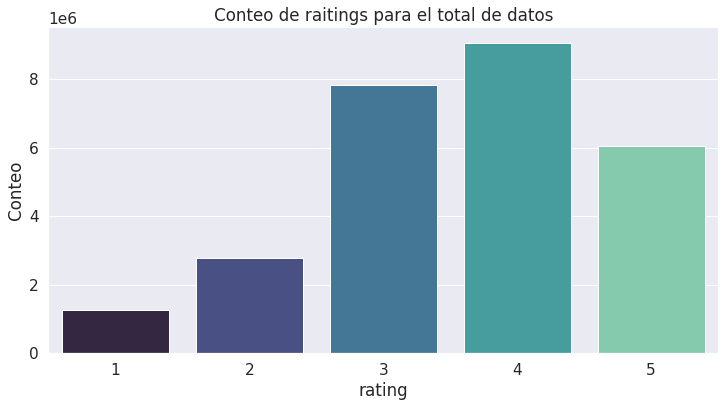

In [ ]:
p = merged_data.select(['rating']) \
               .groupby('rating').agg(F.count('rating').alias('count')) \
               .orderBy(F.col('rating')) \
               .toPandas()

plt.figure(figsize = (12, 6))
sns.set(font_scale = 1.4)
plt.title("Conteo de raitings para el total de datos")
sns.barplot(x = 'rating', y = 'count', data = p, palette = 'mako')
plt.ylabel("Conteo")
plt.show()

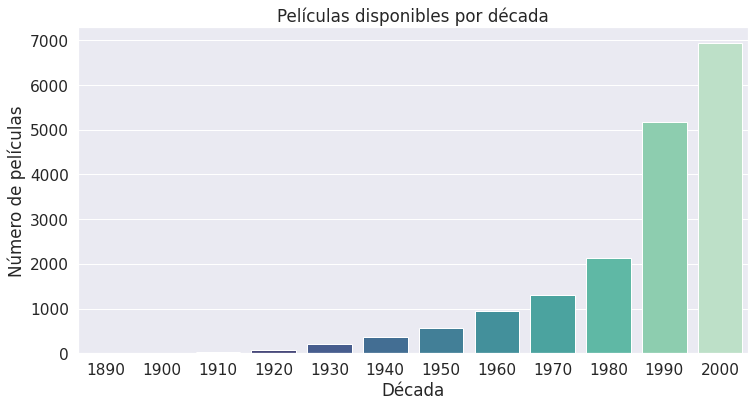

In [ ]:
pelis_porDecada = movies_data.select(['movie_year']) \
                             .withColumn('Decade', F.col('movie_year') - F.col('movie_year') % 10) \
                             .groupby('Decade').agg(F.count('Decade').alias('count')) \
                             .dropna() \
                             .orderBy(F.col('Decade')) \
                             .toPandas()

pelis_porDecada.Decade = pelis_porDecada.Decade.astype('int')

plt.figure(figsize = (12, 6))
sns.barplot(x = 'Decade', y = 'count', data = pelis_porDecada, palette = 'mako')
plt.title("Películas disponibles por década")
plt.xlabel("Década")
plt.ylabel("Número de películas")
plt.show()

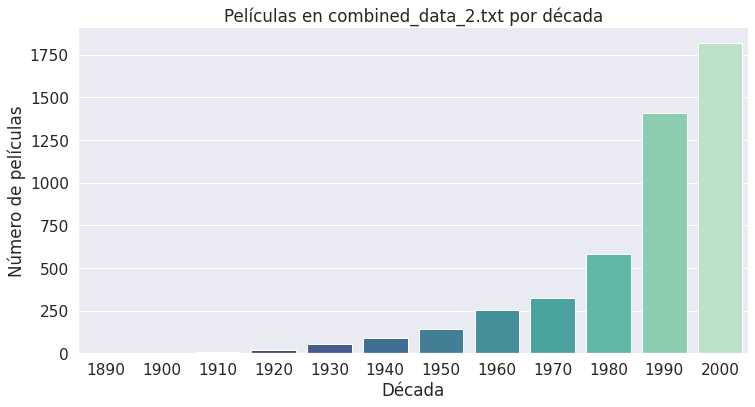

In [ ]:
pelisCD2_porDecada = movies_data.select(['movie_id', 'movie_year']) \
                                .filter(F.col('movie_id').between(4498, 9207)) \
                                .withColumn('Decade', F.col('movie_year') - F.col('movie_year') % 10) \
                                .groupby('Decade').agg(F.count('Decade').alias('count')) \
                                .dropna() \
                                .orderBy(F.col('Decade')) \
                                .toPandas()

pelisCD2_porDecada.Decade = pelisCD2_porDecada.Decade.astype('int')

plt.figure(figsize = (12, 6))
sns.barplot(x = 'Decade', y = 'count', data = pelisCD2_porDecada, palette = 'mako')
plt.title("Películas en combined_data_2.txt por década")
plt.xlabel("Década")
plt.ylabel("Número de películas")
plt.show()

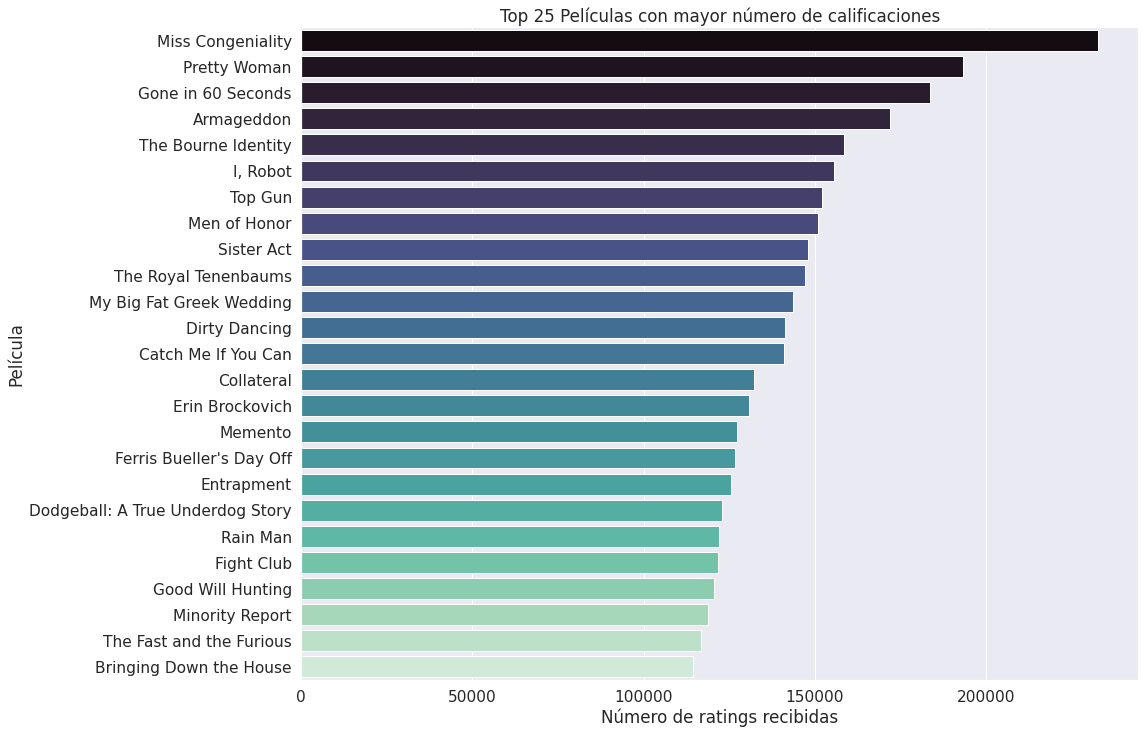

In [ ]:
most_watched_movies = merged_data.select(['movie_name', 'rating']) \
                                 .groupBy('movie_name').agg(F.count('rating').alias('ratings_cnt')) \
                                 .orderBy(F.col('ratings_cnt').desc()) \
                                 .limit(25) \
                                 .toPandas()

plt.figure(figsize = (15, 12))
sns.barplot(data = most_watched_movies, x = 'ratings_cnt', y = 'movie_name', palette = 'mako')
plt.title('Top 25 Películas con mayor número de calificaciones')
plt.ylabel("Película")
plt.xlabel("Número de ratings recibidas")
plt.show()

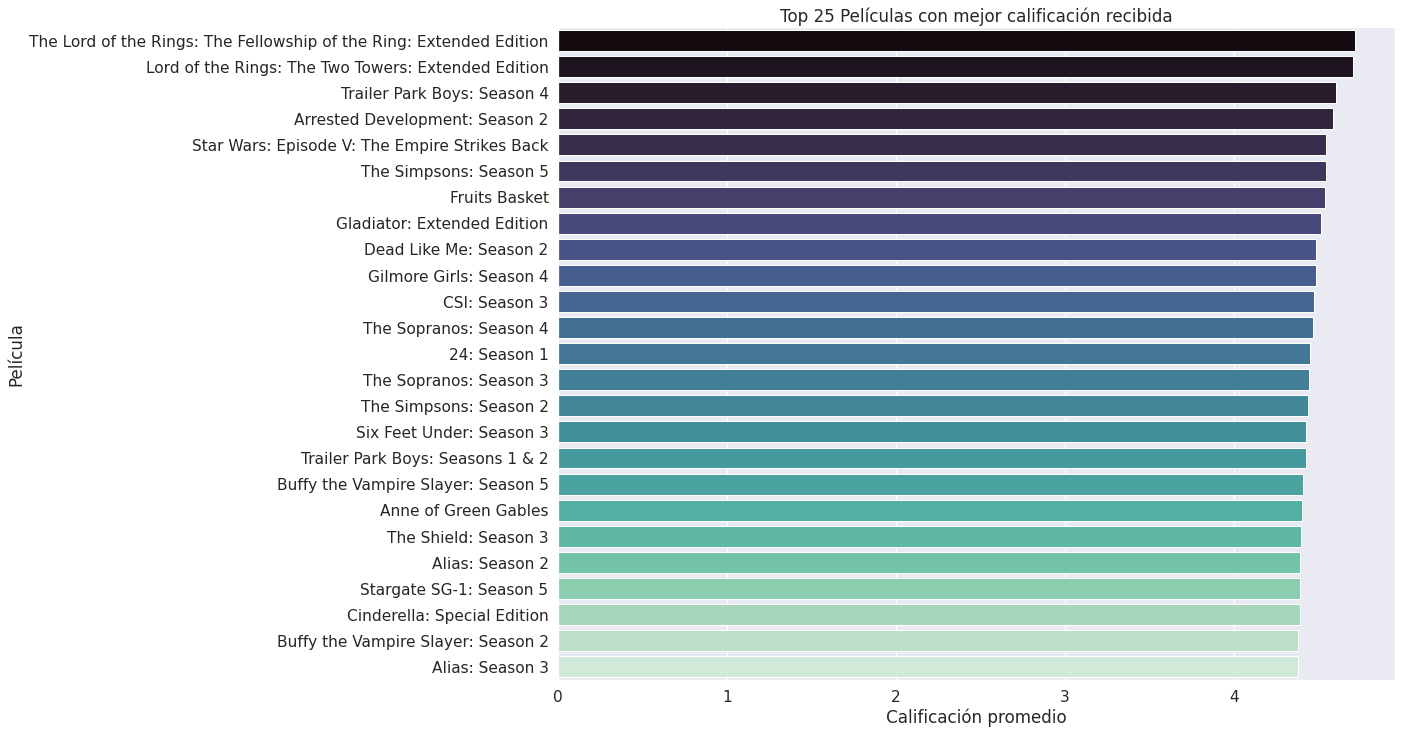

In [ ]:
best_rated_movies = merged_data.select(['movie_name', 'rating']) \
                               .groupBy('movie_name').agg(F.mean('rating').alias('avg_rating')) \
                               .orderBy(F.col('avg_rating').desc()) \
                               .limit(25) \
                               .toPandas()

plt.figure(figsize = (15, 12))
sns.barplot(data = best_rated_movies, x = 'avg_rating', y = 'movie_name', palette = 'mako')
plt.title('Top 25 Películas con mejor calificación recibida')
plt.ylabel("Película")
plt.xlabel("Calificación promedio")
plt.show()

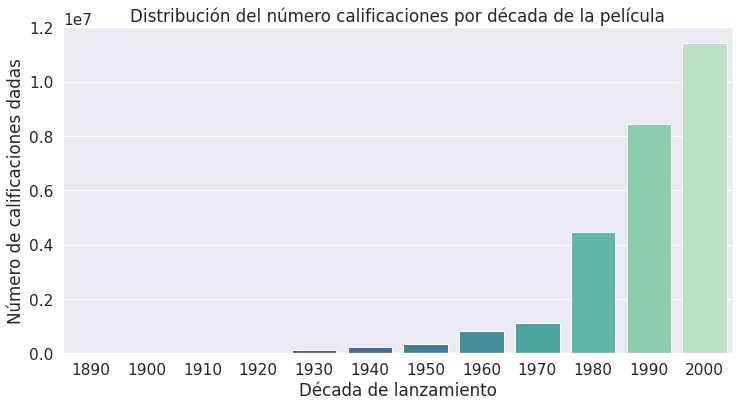

In [ ]:
ratings_count_per_movie_decade = merged_data.select(['movie_id', 'movie_year']) \
                                            .withColumn('Decade', F.col('movie_year') - F.col('movie_year') % 10) \
                                            .groupby('Decade').agg(F.count('Decade').alias('count')) \
                                            .dropna() \
                                            .orderBy(F.col('Decade')) \
                                            .toPandas()

ratings_count_per_movie_decade.Decade = ratings_count_per_movie_decade.Decade.astype('int')

plt.figure(figsize = (12, 6))
sns.barplot(x = 'Decade', y = 'count', data = ratings_count_per_movie_decade, palette = 'mako')
plt.title("Distribución del número calificaciones por década de la película")
plt.xlabel("Década de lanzamiento")
plt.ylabel("Número de calificaciones dadas")
plt.show()

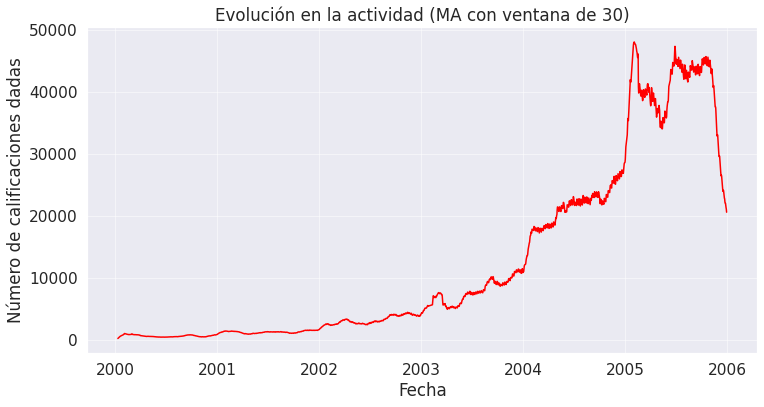

In [ ]:
ratings_cnt_evolution = merged_data.select(['date', 'rating']) \
                                   .groupBy('date').agg(F.count('rating').alias('ratings_cnt')) \
                                   .orderBy('date') \
                                   .toPandas()

ratings_cnt_evolution['date'] = ratings_cnt_evolution.date.astype('datetime64[ns]')
ratings_cnt_evolution['ratings_cnt_ma'] = ratings_cnt_evolution.ratings_cnt.rolling(30).mean()

plt.figure(figsize = (12, 6))
sns.lineplot(data = ratings_cnt_evolution, x = 'date', y = 'ratings_cnt_ma', color = 'red')
plt.grid(alpha = 0.5)
plt.title('Evolución en la actividad (MA con ventana de 30)')
plt.xlabel("Fecha")
plt.ylabel("Número de calificaciones dadas")
plt.show()

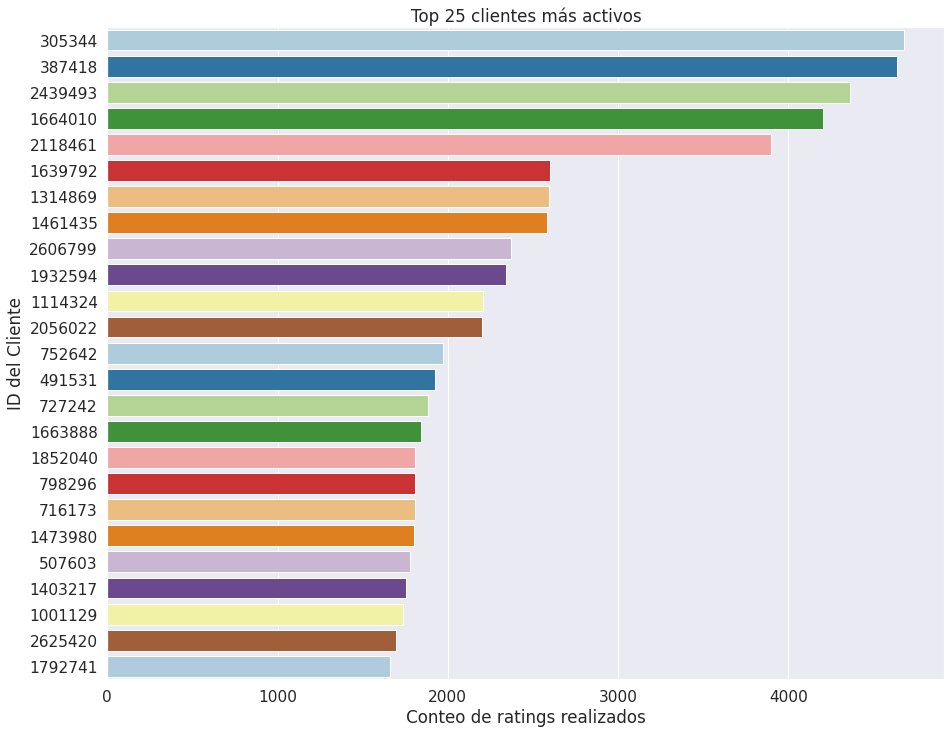

In [ ]:
most_active_customers = merged_data.select(['customer_id', 'rating']) \
                                   .groupBy('customer_id').agg(F.count('rating').alias('ratings_cnt')) \
                                   .orderBy(F.col('ratings_cnt').desc()) \
                                   .limit(25) \
                                   .toPandas()

most_active_customers.customer_id = most_active_customers.customer_id.astype('str')

plt.figure(figsize = (15, 12))
sns.set(font_scale = 1.4)
sns.barplot(data = most_active_customers, x = 'ratings_cnt', y = 'customer_id', palette = 'Paired')
plt.title('Top 25 clientes más activos')
plt.xlabel("Conteo de ratings realizados")
plt.ylabel("ID del Cliente")
plt.show()

### Preprocesamiento

En primer lugar utilizaremos un par de modelos con los cuales utilizaremos los dataframes de Pandas. Cabe destacar, tambien, que el más grande problema con el que nos enfrentamos durante esta fase fue la gran cantidad de datos. Para solucionar este problema utilizaremos una muestra de los registros.

In [ ]:
import glob

In [ ]:
merged_data.limit(int(merged_data.count()*0.25)).count()

6744397

Seleccionamos solo el primer cuarto de los datos, esto debido a que la librería de surprise puede ser sensible a una gran cantidad de datos.

In [ ]:
merged_data.coalesce(1).write.csv('ratings.csv')
#merged_data.sample(0.25).coalesce(1).write.csv('sample_ratings.csv')
merged_data.limit(int(merged_data.count()*0.25)).coalesce(1).write.csv('sample_ratings.csv')

In [ ]:
glob.glob("/content/sample_ratings.csv/*")[1]

'/content/sample_ratings.csv/part-00000-faf0e835-4c04-4a33-b763-19934086c8c4-c000.csv'

In [ ]:
df = pd.read_csv(glob.glob("/content/ratings.csv/*")[1], names = ['movie_id', 'customer_id', 'rating', 'date', 'movie_year', 'movie_name'])
df_rating = pd.read_csv(glob.glob("/content/sample_ratings.csv/*")[1], names = ['movie_id', 'customer_id', 'rating', 'date', 'movie_year', 'movie_name'])

In [ ]:
df.head()

,movie_id,customer_id,rating,date,movie_year,movie_name
0,4519,1646939,2,2005-07-08,2003.0,Out for a Kill
1,4519,1276913,5,2005-04-18,2003.0,Out for a Kill
2,4519,43601,5,2003-08-27,2003.0,Out for a Kill
3,4519,183907,2,2004-03-03,2003.0,Out for a Kill
4,4519,1206156,1,2003-09-16,2003.0,Out for a Kill


Para el preprocesamiento primero creamos una función que nos indique el número de películas, usuarios y calificaciones otorgadas en el dataset que le pasemos por parámetro, en nuestro caso le pasamos el 

In [ ]:
def imprimir_noElementos(datos_preprocesados):
    movie_count = datos_preprocesados.isnull().sum()[1]
    print("Número de películas: {}".format(movie_count))
    #Se obtiene el total de usuarios 
    users_count = datos_preprocesados[datos_preprocesados['rating'].notnull()]['customer_id'].nunique() 
    #Se obtiene el total de ratings
    rating_count = datos_preprocesados['customer_id'].count() - movie_count
    print("""Se tiene un total de {} usuarios 
que han asignado {} calificaciones""".format(users_count, rating_count))
#imprimir_noElementos(df_raiting)

In [ ]:
print("En nuestros datos originales tenemos.\n")
imprimir_noElementos(df)
print("En el subconjunto de datos tenemos.\n")
imprimir_noElementos(df_rating)

En nuestros datos originales tenemos.

Número de películas: 0
Se tiene un total de 474062 usuarios 
que han asignado 26977591 calificaciones
En el subconjunto de datos tenemos.

Número de películas: 0
Se tiene un total de 444235 usuarios 
que han asignado 6744397 calificaciones


Creamos una función con la que se obtengan los usuarios que menor interacción así como las películas con menor número de calificaciones recibidas. Con otra función, filtramos de nuestro conjunto de datos a estos usuarios y películas pues podrían generar ruido en el modelado final.

In [ ]:
def obtener_menosPop(datos,cal_col,umbral_usuario,umbral_peli,imprimirCant=False):
    f = ['count','mean']
    # Obtener lista de películas menos populares
    df_movie_summary = datos.groupby('movie_id')[cal_col].agg(f)
    df_movie_summary.index = df_movie_summary.index.map(int)
    movie_benchmark = round(df_movie_summary['count'].quantile(umbral_peli),0)
    drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
    # Obtener lista de usuarios menos activos
    df_cust_summary = datos.groupby('customer_id')[cal_col].agg(f)
    df_cust_summary.index = df_cust_summary.index.map(int)
    cust_benchmark = round(df_cust_summary['count'].quantile(umbral_usuario),0)
    drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
    # Imprimir número de elementos menos frecuentes
    if imprimirCant:
        print("Número de películas menos populares: {}".format(movie_benchmark))
        print('Usuarios menos activos: {}'.format(cust_benchmark))
    return drop_movie_list, drop_cust_list
    
def filtrar_dataset(datos,lista_pel_rem,lista_usuario_rem,imprimirComparacion=False):
    df_reduced = datos[~datos['movie_id'].isin(lista_pel_rem)]
    df_reduced = df_reduced[~df_reduced['customer_id'].isin(lista_usuario_rem)]
    if imprimirComparacion:
        print('Tamaño original: {}'.format(datos.shape))
        print('Tamaño después de la reducción: {}'.format(df_reduced.shape))
    return df_reduced

In [ ]:
peliculas_remover,clientes_remover = obtener_menosPop(df_rating,'rating',0.9,0.8,True)
df_raitingFil = filtrar_dataset(df_rating,peliculas_remover,clientes_remover,True)

Número de películas menos populares: 4643.0
Usuarios menos activos: 38.0
Tamaño original: (6744397, 6)
Tamaño después de la reducción: (2398184, 6)


In [ ]:
df_raitingFil.head()

,movie_id,customer_id,rating,date,movie_year,movie_name
3514,5156,921064,5,2005-07-07,2004.0,Blue Collar Comedy Tour Rides Again
3518,5156,1693641,5,2005-07-26,2004.0,Blue Collar Comedy Tour Rides Again
3519,5156,2152963,4,2005-07-26,2004.0,Blue Collar Comedy Tour Rides Again
3521,5156,2257304,5,2005-08-10,2004.0,Blue Collar Comedy Tour Rides Again
3522,5156,395744,3,2005-08-13,2004.0,Blue Collar Comedy Tour Rides Again


## Entrenamiento modelo con surprise

In [ ]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [ ]:
#Esta dataframe, lo reservaremos para generar las recomendaciones
movies = df_movies.copy() #hacemos una copia de df_movies
movies = movies.reset_index()
movies = movies[~movies['movie_id'].isin(peliculas_remover)]

### SVD

In [ ]:
# Traemos la base de datos completa
reader = Reader()
data = Dataset.load_from_df(df_raitingFil[['customer_id', 'movie_id', 'rating']], reader)

In [ ]:
#@title Entrenamiento/Validación

trainset, testset = train_test_split(data, 
                                test_size=.25)
svd = SVD() #definición del modelo
#trainset = data.build_full_trainset() #data.build_full_trainset()
svd.fit(trainset) #entrenamiento

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

Rendimiento sobre conjunto de prueba
RMSE: 0.8702
0.8701521459848752


In [ ]:
# @title Validación cruzada
n_jobs = 1 #Cambiar a -1 si hay más CPUs
res = cross_validate(svd, 
               data, 
               measures = ['RMSE'], 
               cv=3, 
               verbose=True, 
               n_jobs=n_jobs)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8927  0.8915  0.8905  0.8915  0.0009  
Fit time          135.29  137.52  137.44  136.75  1.03    
Test time         15.42   15.75   15.67   15.62   0.14    


In [ ]:
# @title GridSearch (No ejecutar)
#param_grid = {'lr_all':[0.001,0.005],
#              'reg_all':[0.1,0.4]}
#gs = GridSearchCV(SVD, 
#                  param_grid, 
#                  measures=['rmse'], 
#                  cv=5)
#gs.fit(data)
# best RMSE score
#print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

### SVD++

In [ ]:
#@title Entrenamiento/Validación
svdpp = SVDpp()
svdpp.fit(trainset) #entrenamiento

print("Rendimiento sobre conjunto de prueba")
predictions = svdpp.test(testset)
print(accuracy.rmse(predictions))

Rendimiento sobre conjunto de prueba
RMSE: 0.8595
0.8594860023964359


In [ ]:
# @title Validación cruzada
n_j = 1 #Cambiar a -1 si se cuenta con más CPUs
res = cross_validate(svdpp, 
               data, 
               measures = ['RMSE'], 
               cv=3, 
               verbose=True, 
               n_jobs=n_j)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8784  0.8771  0.8781  0.8779  0.0005  
Fit time          1020.98 1029.36 1046.58 1032.31 10.66   
Test time         101.72  101.21  106.50  103.14  2.38    


In [ ]:
# @title GridSearch (No ejecutar)
#param_grid = {'lr_all':[0.002,0.007],
#              'reg_all':[0.1,0.4]}
#gs = GridSearchCV(SVDpp, 
#                  param_grid, 
#                  measures=['rmse'], 
#                  cv=5)
#gs.fit(data)
# best RMSE score
#print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

## Predicción con surprise

In [ ]:
""" Analicemos a un usuario en particular """
userid= 1664010#user_id de un usuario específico 
user = df_raitingFil[(df_raitingFil['customer_id'] == userid) & (df_raitingFil['rating'] == 5)]
user = user.set_index('movie_id')
user = user['movie_name']
print("Películas que ha visto el usuario "+str(userid))
print(user)

Películas que ha visto el usuario 1664010
movie_id
5156    Blue Collar Comedy Tour Rides Again
5071                            Fever Pitch
5287                       Bonnie and Clyde
5345                             Shark Tale
5223                      Girl, Interrupted
                       ...                 
5612          Kids in the Hall: Brain Candy
5992             La Strada: Special Edition
6060                       Cold Creek Manor
5967               The Lizzie McGuire Movie
5862                                Memento
Name: movie_name, Length: 187, dtype: object


In [ ]:
movies = movies[~movies.movie_id.isin(user.index.tolist())]
movies['Estimate_Score_SVD'] = movies['movie_id'].apply(lambda x: svd.predict(userid, x).est)
movies = movies.sort_values('Estimate_Score_SVD', ascending=False)
movies.head(20)

,index,movie_id,movie_year,movie_name,Estimate_Score_SVD
0,0,1,2003,Dinosaur Planet,4.96217
11841,11841,11842,2005,Bewafaa,4.96217
11847,11847,11848,1997,For Richer or Poorer,4.96217
11846,11846,11847,2005,Dust to Glory,4.96217
11845,11845,11846,1985,Prizzi's Honor,4.96217
11836,11836,11837,1987,Three Men and a Baby,4.96217
11843,11843,11844,1967,Barefoot in the Park,4.96217
11842,11842,11843,1993,NYPD Blue: Season 1,4.96217
11840,11840,11841,2004,Cleopatra,4.96217
11832,11832,11833,1997,All Over Me,4.96217


In [ ]:
movies = movies[~movies.movie_id.isin(user.index.tolist())]
movies['Estimate_Score_SVDpp'] = movies['movie_id'].apply(lambda x: svdpp.predict(userid, x).est)
movies = movies.sort_values('Estimate_Score_SVDpp', ascending=False)
movies.head(20)

,index,movie_id,movie_year,movie_name,Estimate_Score_SVD,Estimate_Score_SVDpp
0,0,1,2003,Dinosaur Planet,4.96217,4.950448
14,14,15,1988,Neil Diamond: Greatest Hits Live,4.96217,4.950448
33,33,34,2003,Ashtanga Yoga: Beginner's Practice with Nicki ...,4.96217,4.950448
8,8,9,1991,Class of Nuke 'Em High 2,4.96217,4.950448
10,10,11,1999,Full Frame: Documentary Shorts,4.96217,4.950448
36,36,37,1973,Zatoichi's Conspiracy,4.96217,4.950448
12,12,13,2003,Lord of the Rings: The Return of the King: Ext...,4.96217,4.950448
13,13,14,1982,Nature: Antarctica,4.96217,4.950448
15,15,16,1996,Screamers,4.96217,4.950448
64,64,65,2000,Lost in the Pershing Point Hotel,4.96217,4.950448


## Entrenamiento utilizando Pyspark

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [ ]:
als = ALS(maxIter = 5, regParam = 0.01, userCol = "customer_id", itemCol = "movie_id", ratingCol = "rating", coldStartStrategy = "drop")
model = als.fit(merged_data)

In [ ]:
train_predictions = model.transform(merged_data)
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")
rmse = evaluator.evaluate(train_predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.786247766803661


In [ ]:
customer_preferred_movies = merged_data.select(['customer_id', 'movie_id', 'movie_name', 'rating']) \
                                       .filter(F.col('customer_id') == 1331154) \
                                       .orderBy(F.col('rating').desc())

customer_preferred_movies.show(30)

+-----------+--------+--------------------+------+
|customer_id|movie_id|          movie_name|rating|
+-----------+--------+--------------------+------+
|    1331154|    5862|             Memento|     5|
|    1331154|    8379|  Enemy at the Gates|     5|
|    1331154|    5738|     Alias: Season 3|     5|
|    1331154|    4627|        Little Women|     5|
|    1331154|    5778|The Godfather, Pa...|     5|
|    1331154|    4805|        True Romance|     5|
|    1331154|    5696|The X-Files: Seas...|     5|
|    1331154|    5292|     Alias: Season 2|     5|
|    1331154|    5762|       Almost Famous|     5|
|    1331154|    5169|     My Cousin Vinny|     5|
|    1331154|    6037| The Bourne Identity|     5|
|    1331154|    5886|The X-Files: Seas...|     5|
|    1331154|    5582|Star Wars: Episod...|     5|
|    1331154|    7742|Six Feet Under: S...|     5|
|    1331154|    8079|Interview with th...|     5|
|    1331154|    7230|The Lord of the R...|     5|
|    1331154|    4849|         

In [ ]:
test = movies_data.withColumn('customer_id', F.lit(1331154)) \
                  .withColumn('movie_id', F.col('movie_id').cast(IntegerType())) \
                  .join(customer_preferred_movies, on = 'movie_id', how = 'leftanti')
test.show(5)

+--------+----------+--------------------+-----------+
|movie_id|movie_year|          movie_name|customer_id|
+--------+----------+--------------------+-----------+
|       1|      2003|     Dinosaur Planet|    1331154|
|       2|      2004|Isle of Man TT 20...|    1331154|
|       3|      1997|           Character|    1331154|
|       4|      1994|Paula Abdul's Get...|    1331154|
|       5|      2004|The Rise and Fall...|    1331154|
+--------+----------+--------------------+-----------+
only showing top 5 rows



In [ ]:
predictions = model.transform(test) \
                   .orderBy(F.col('prediction').desc())                   
predictions.show(30)

+--------+----------+--------------------+-----------+----------+
|movie_id|movie_year|          movie_name|customer_id|prediction|
+--------+----------+--------------------+-----------+----------+
|    9040|      1999|The Sixth Sense: ...|    1331154| 5.6757817|
|    7303|      2002|  Coupling: Season 3|    1331154|  4.632561|
|    8226|      2000|Buffy the Vampire...|    1331154|  4.597307|
|    6241|      1965|Operation "Y" and...|    1331154|  4.593317|
|    7569|      2004|Dead Like Me: Sea...|    1331154|  4.578537|
|    7815|      2003|Gilmore Girls: Se...|    1331154|  4.562971|
|    7110|      2004|The Shield: Season 3|    1331154|  4.485126|
|    5092|      1997|Buffy the Vampire...|    1331154|   4.47342|
|    7235|      2003| Carnivale: Season 1|    1331154| 4.4474216|
|    9124|      1996|          Underworld|    1331154|  4.435523|
|    7664|      2000|Gladiator: Extend...|    1331154|   4.42949|
|    6925|      2005|Dalai Lama: The S...|    1331154| 4.3822002|
|    9101|

In [ ]:
userRecs = model.recommendForAllUsers(10)
userRecs.show(10)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----------+--------------------+
|customer_id|     recommendations|
+-----------+--------------------+
|        126|[{7376, 7.167574}...|
|        183|[{4806, 7.738264}...|
|        192|[{6925, 5.235989}...|
|        296|[{7003, 4.8396387...|
|        368|[{4806, 9.666292}...|
|        384|[{4806, 9.256855}...|
|        385|[{4806, 10.083525...|
|        392|[{9052, 5.1746135...|
|        471|[{6925, 4.774124}...|
|        481|[{4806, 8.622595}...|
+-----------+--------------------+
only showing top 10 rows

